In [1]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

Using TensorFlow backend.


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from random import shuffle

In [3]:
tr_data_DIR = 'train-scene classification/'
IMG_DIR = 'train-scene classification/train'

tr_data = pd.read_csv(tr_data_DIR+'/'+'train.csv')
test_data = pd.read_csv('test_WyRytb0.xls')

In [4]:
IMG_SIZE = 224

In [5]:
def create_train_data():
    training_data = []
    for i in (range(tr_data.shape[0])):
        pic = tr_data.image_name[i]
        label = tr_data.label[i]
        path = os.path.join(IMG_DIR,pic)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [6]:
def create_test_data():
    testing_data = []
    for i in (range(test_data.shape[0])):
        pic = test_data.image_name[i]
        path = os.path.join(IMG_DIR,pic)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img)])
    np.save('test_data.npy', testing_data)
    return testing_data

In [7]:
#train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy')

In [8]:
#test_data = create_test_data()
# If you have already created the dataset:
test_data = np.load('test_data.npy')

In [9]:
X_train = np.array([i[0] for i in train_data])
y_train = [i[1] for i in train_data]

assert X_train.shape[0] == len(y_train)

X_test = np.array([i[0] for i in test_data])

In [10]:
print(X_test.shape)
print(X_train.shape)
print(len(y_train))

(7301, 224, 224, 3)
(17034, 224, 224, 3)
17034


In [11]:
# datagen=ImageDataGenerator(rescale=1./255.,
#                            width_shift_range=0.1,
#                            height_shift_range=0.1,
#                            shear_range=0.1,
#                            zoom_range=0.2,
#                            horizontal_flip=True,
#                            validation_split=0.25)

# train_generator=datagen.flow_from_dataframe(dataframe=tr_data, directory=IMG_DIR, x_col="image_name", y_col="label",
#                                             subset="training", batch_size=32, seed=42, shuffle=True, color_mode='rgb',
#                                             class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE))

# valid_generator=datagen.flow_from_dataframe(dataframe=tr_data, directory=IMG_DIR, x_col="image_name", y_col="label",
#                                             subset="validation", batch_size=32, seed=42, shuffle=True, color_mode='rgb',
#                                             class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE))

# test_datagen=ImageDataGenerator(rescale=1./255.)

# test_generator=test_datagen.flow_from_dataframe(dataframe=test_data, directory=IMG_DIR, x_col="image_name",
#                                                 batch_size=1, seed=42, shuffle=False, color_mode='rgb', class_mode=None,
#                                                 target_size=(IMG_SIZE,IMG_SIZE))

In [12]:
import numpy as np
import os
import time
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
from keras.optimizers import Adam, SGD

from keras_applications.imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [13]:
image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [14]:
model = ResNet50(input_tensor=image_input, include_top=False, weights='imagenet')
model.summary()

/home/intern001/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
last_layer = model.output
x = GlobalAveragePooling2D()(last_layer)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dropout(0.5)(x)

In [16]:
out = Dense(6, activation='softmax', name='output_layer')(x)

In [17]:
custom_model = Model(inputs=image_input, outputs=out)
custom_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [18]:
for layer in custom_model.layers[:-10]:
    layer.trainable = False

In [19]:
custom_model.layers[-1].trainable

True

In [20]:
custom_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
custom_model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=1e-4,momentum=0.99),metrics=['accuracy'])

In [22]:


X_train = X_train.reshape(17034, 224,224, 3)
X_test = X_test.reshape(7301, 224,224, 3)

num_classes = 6

y_train = to_categorical(y_train, 6)
#y_train = np.expand_dims(y_train, -1)

In [23]:
PATH = 'base.model'
checkpoint = ModelCheckpoint(PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)


csvlogger = CSVLogger(filename= "training_csv.log", separator = ",", append = False )


reduce = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=1, verbose=1, mode='min')

callbacks_list = [checkpoint,csvlogger,reduce]

In [24]:
#history = custom_model.fit_generator(train_generator, steps_per_epoch=train_generator.samples//64,validation_data=valid_generator, validation_steps=valid_generator.samples//64, epochs=12, verbose=1)

history = custom_model.fit(X_train, y_train, batch_size=128, epochs=35, validation_split=0.3, verbose=1, callbacks = callbacks_list)


#history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64), steps_per_epoch=200, epochs=35,verbose=1, validation_data=datagen.flow(X_train, y_train, batch_size=64), validation_steps=100)


Train on 11923 samples, validate on 5111 samples
Epoch 1/35
11923/11923 [==============================] - 47s 4ms/step - loss: 1.7976 - acc: 0.3203 - val_loss: 0.8877 - val_acc: 0.7699

Epoch 00001: val_loss improved from inf to 0.88771, saving model to base.model
Epoch 2/35
11923/11923 [==============================] - 40s 3ms/step - loss: 0.8244 - acc: 0.6914 - val_loss: 0.5218 - val_acc: 0.8032

Epoch 00002: val_loss improved from 0.88771 to 0.52180, saving model to base.model
Epoch 3/35
11923/11923 [==============================] - 40s 3ms/step - loss: 0.5485 - acc: 0.7950 - val_loss: 0.4589 - val_acc: 0.8231

Epoch 00003: val_loss improved from 0.52180 to 0.45892, saving model to base.model
Epoch 4/35
11923/11923 [==============================] - 40s 3ms/step - loss: 0.4363 - acc: 0.8362 - val_loss: 0.4530 - val_acc: 0.8315

Epoch 00004: val_loss improved from 0.45892 to 0.45296, saving model to base.model
Epoch 5/35
11923/11923 [==============================] - 40s 3ms/step 

11923/11923 [==============================] - 40s 3ms/step - loss: 0.3046 - acc: 0.8893 - val_loss: 0.4417 - val_acc: 0.8327

Epoch 00032: val_loss did not improve from 0.43224

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.4901160817412662e-12.
Epoch 33/35
11923/11923 [==============================] - 40s 3ms/step - loss: 0.3118 - acc: 0.8859 - val_loss: 0.4417 - val_acc: 0.8327

Epoch 00033: val_loss did not improve from 0.43224

Epoch 00033: ReduceLROnPlateau reducing learning rate to 7.450580408706331e-13.
Epoch 34/35
11923/11923 [==============================] - 40s 3ms/step - loss: 0.3050 - acc: 0.8909 - val_loss: 0.4417 - val_acc: 0.8327

Epoch 00034: val_loss did not improve from 0.43224

Epoch 00034: ReduceLROnPlateau reducing learning rate to 3.7252902043531655e-13.
Epoch 35/35
11923/11923 [==============================] - 40s 3ms/step - loss: 0.3077 - acc: 0.8890 - val_loss: 0.4417 - val_acc: 0.8327

Epoch 00035: val_loss did not improve from 0.43224

Epoch 

Text(0.5,0,'epoch')

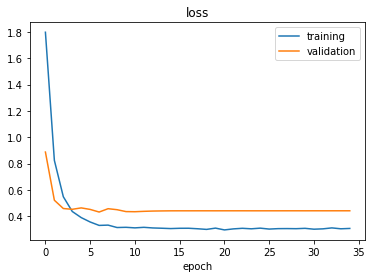

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

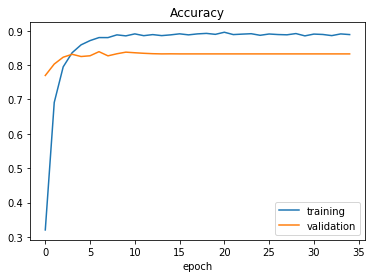

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [35]:
custom_model.predict(X_test)

array([[1.1238048e-04, 7.6275214e-06, 3.0664876e-06, 5.9633328e-07,
        2.3161449e-05, 9.9985313e-01],
       [9.4649285e-01, 3.1764500e-04, 3.5650646e-05, 5.6783796e-05,
        4.3422476e-04, 5.2662857e-02],
       [1.0106956e-05, 3.8602931e-05, 6.4185704e-04, 5.9066620e-04,
        9.9869752e-01, 2.1221578e-05],
       ...,
       [4.0217530e-04, 1.0697371e-03, 5.9865326e-01, 2.1105759e-01,
        1.8865772e-01, 1.5958147e-04],
       [8.1129319e-06, 9.9996984e-01, 4.5935476e-06, 1.0663504e-05,
        6.1489977e-06, 6.3354298e-07],
       [6.4477098e-01, 5.4563889e-03, 3.4994625e-03, 3.1805320e-03,
        1.9675443e-01, 1.4633818e-01]], dtype=float32)

In [36]:
pred = custom_model.predict(X_test)

In [37]:
predicted_classes = np.argmax(pred, axis=1)
predicted_classes

array([5, 0, 4, ..., 2, 1, 0])

In [38]:
predicted_classes[:50]

array([5, 0, 4, 3, 5, 1, 4, 3, 3, 2, 2, 1, 0, 3, 1, 5, 4, 5, 0, 3, 1, 5,
       2, 3, 1, 5, 1, 2, 0, 4, 3, 3, 5, 5, 2, 4, 3, 4, 5, 4, 0, 5, 3, 0,
       0, 1, 1, 0, 4, 5])

In [39]:
import csv
data = []
testxl = pd.read_csv('test_WyRytb0.xls')

with open('submission_transfer_1.csv', 'a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames = ["image_name", "label"])
    writer.writeheader()
    for i in range(testxl.shape[0]):
        img = testxl.image_name[i]
        label = predicted_classes[i]
        data.append(img)
        data.append(label)
        writer = csv.writer(file, delimiter=',')
        writer.writerow(data)
        data = []

In [40]:
model.save('submission_transfer_1.hdf5')